In [859]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [860]:
matplotlib.rcParams.update({'font.size': 14})

In [861]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

In [862]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREPARED_DATASET_PATH = 'Krukovich_predictions.csv'

**Описание датаесета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [863]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [864]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


### Общая информация о датасете

In [865]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [866]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [867]:
train_df.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

**Приведение типов данных**

In [868]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)

In [869]:
test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

### Обзор данных

**Количественные переменные**

In [870]:
train_df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
train_df_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


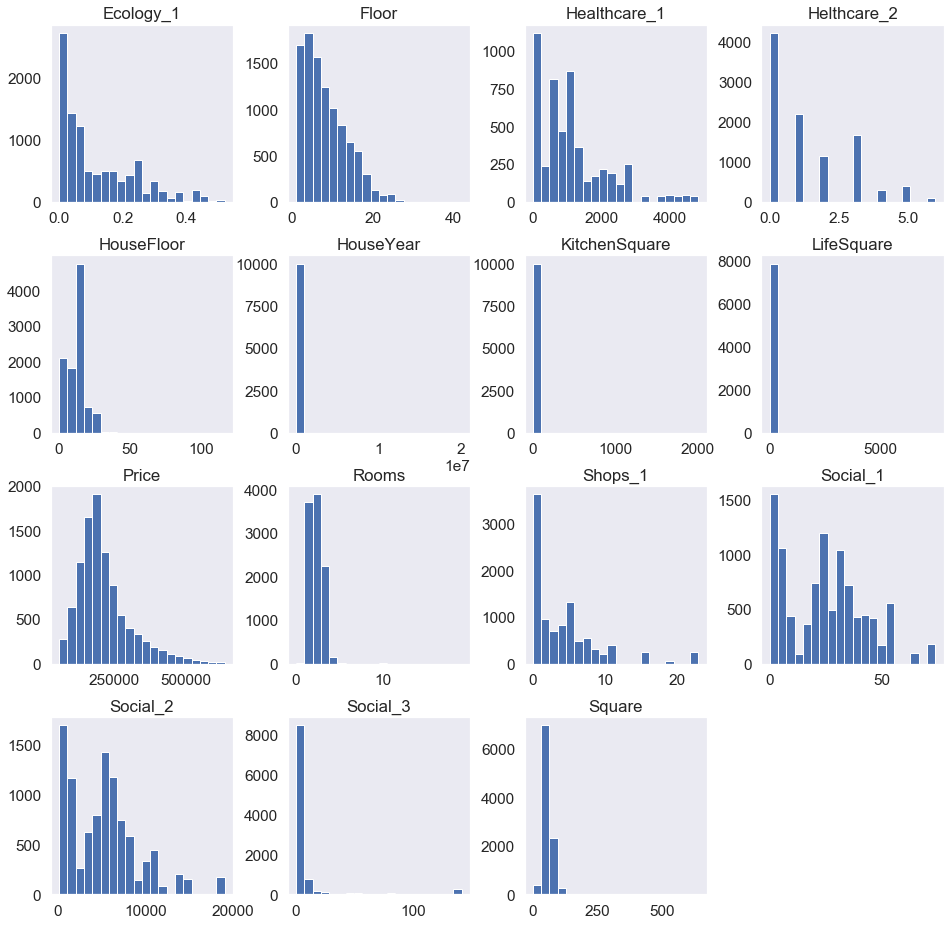

In [871]:
train_df_num_features.hist(figsize=(16,16), bins=20, grid=False);

**Номинативные переменные**

In [873]:
train_df_obj_features = train_df.select_dtypes(include='object')
train_df_obj_features.tail()

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
9995,77,32,B,B,B
9996,6159,18,B,B,A
9997,5123,27,B,B,A
9998,5400,75,B,A,B
9999,6306,128,B,B,B


In [874]:
cat_colnames = train_df.select_dtypes(include='object').columns.tolist()
cat_colnames

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [875]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(train_df[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Ecology_2

B    9903
A      97
Name: Ecology_2, dtype: int64
****************************************************************************************************

Ecology_3

B    9725
A     275
Name: Ecology_3, dtype: int64
****************************************************************************************************

Shops_2

B    9175
A     825
Name: Shops_2, dtype: int64
****************************************************************************************************



**Целевая переменная**

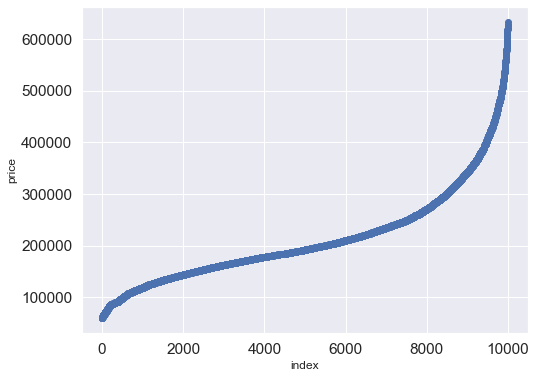

In [876]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.Price.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

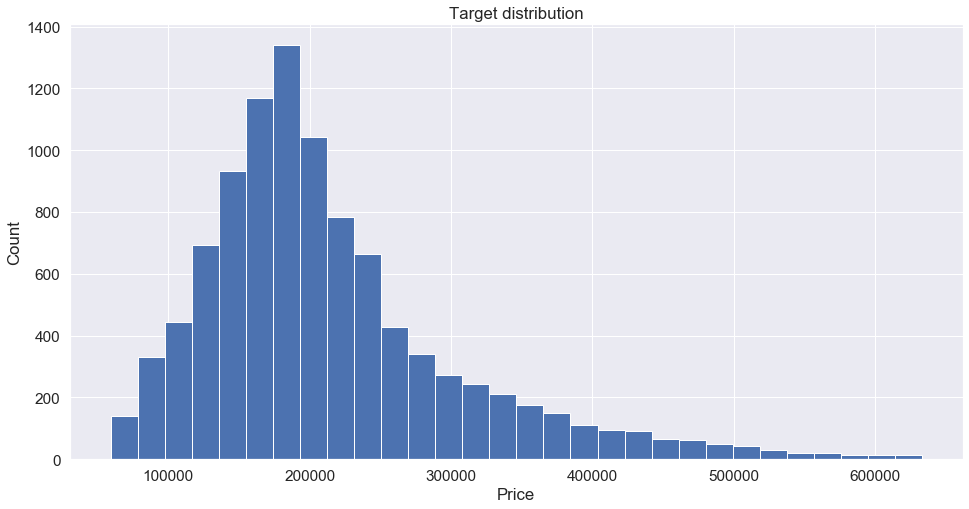

In [877]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [878]:
price_mean = round(train_df['Price'].mean(), 2)
price_median = train_df['Price'].median()
price_mode = train_df['Price'].mode()[0]

price_mean, price_median, price_mode

(214138.86, 192269.64487934904, 59174.77802758122)

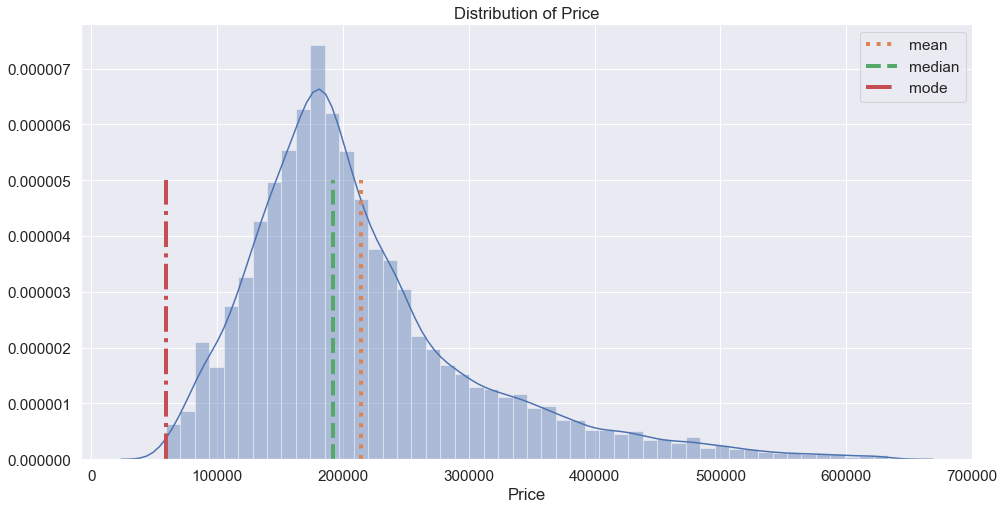

In [879]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'])

y = np.linspace(0, 0.000005, 100)
plt.plot([price_mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([price_median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([price_mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

### Обработка выбросов

**Rooms**

In [880]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

Для наблюдений у которых количетсво комнат 0 и больше 5, произведем замену на медиану.

In [881]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

In [882]:
test_df.loc[test_df['Rooms'].isin([0, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

**Square, LifeSquare, KitchenSquare**

Обрежим выбросы по квантилям с каждой стороны Square, LifeSquare и KitchenSquare

In [883]:
train_df = train_df[train_df['Square'].isnull() |
                    (train_df['Square'] < train_df['Square'].quantile(.99)) &
                    (train_df['Square'] > train_df['Square'].quantile(.01))]

train_df = train_df[train_df['LifeSquare'].isnull() |
                    (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.99)) &
                    (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.01))]

train_df = train_df[train_df['KitchenSquare'].isnull() |
                    (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.99)) &
                    (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.01))]

In [884]:
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742


In [885]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [886]:
train_df.shape

(8881, 20)

In [887]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,8881.000000,8881.000000,7296.000000,8881.000000,8881.000000,8881.000000,8.881000e+03,8881.000000,8881.000000,8881.000000,8881.000000,4799.000000,8881.000000,8881.000000,8881.000000
mean,1.884585,54.809487,34.830304,6.075329,8.446684,12.826934,4.242532e+03,0.119620,26.071163,5630.480014,8.403783,1156.072932,1.392636,4.438577,214939.479049
std,0.797003,16.225349,14.280535,3.503611,5.133763,6.369206,2.127571e+05,0.119654,17.269698,3977.902810,24.295214,1032.814421,1.492092,4.837340,89654.209673
min,1.000000,29.719934,2.941437,1.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.637555,22.863805,1.000000,4.000000,9.000000,1.972000e+03,0.017647,10.000000,2370.000000,0.000000,325.000000,0.000000,1.000000,156934.440088
50%,2.000000,51.656012,32.459931,6.000000,7.000000,14.000000,1.977000e+03,0.075779,25.000000,5562.000000,2.000000,990.000000,1.000000,3.000000,194240.534503
75%,2.000000,64.720916,44.119769,9.000000,12.000000,17.000000,2.000000e+03,0.194489,36.000000,7614.000000,5.000000,1548.000000,3.000000,6.000000,250381.580780
max,6.000000,117.855969,88.381356,14.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Значения LifeSquare < 10, заменим на 10.

In [888]:
train_df.loc[train_df['LifeSquare'] < 10, 'LifeSquare'] = 10

In [889]:
test_df.loc[test_df['LifeSquare'] < 10, 'LifeSquare'] = 10

Значения KitchenSquare < 3, заменим на 3.

In [890]:
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

In [891]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,8881.000000,8881.000000,7296.000000,8881.000000,8881.000000,8881.000000,8.881000e+03,8881.000000,8881.000000,8881.000000,8881.000000,4799.000000,8881.000000,8881.000000,8881.000000
mean,1.884585,54.809487,34.909291,6.589798,8.446684,12.826934,4.242532e+03,0.119620,26.071163,5630.480014,8.403783,1156.072932,1.392636,4.438577,214939.479049
std,0.797003,16.225349,14.126708,2.795883,5.133763,6.369206,2.127571e+05,0.119654,17.269698,3977.902810,24.295214,1032.814421,1.492092,4.837340,89654.209673
min,1.000000,29.719934,10.000000,3.000000,1.000000,0.000000,1.914000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.637555,22.863805,3.000000,4.000000,9.000000,1.972000e+03,0.017647,10.000000,2370.000000,0.000000,325.000000,0.000000,1.000000,156934.440088
50%,2.000000,51.656012,32.459931,6.000000,7.000000,14.000000,1.977000e+03,0.075779,25.000000,5562.000000,2.000000,990.000000,1.000000,3.000000,194240.534503
75%,2.000000,64.720916,44.119769,9.000000,12.000000,17.000000,2.000000e+03,0.194489,36.000000,7614.000000,5.000000,1548.000000,3.000000,6.000000,250381.580780
max,6.000000,117.855969,88.381356,14.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [892]:
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3

**HouseFloor, Floor**

In [893]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  32.,  37.,
        39.,  40.,  44.,  45.,  48.,  99., 117.])

Все значения этажей в доме равные нулю изменю на медиану.

In [894]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [895]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

Предположу, что значение 99 и 117 это опечатка. Заменю на 9 и 17.

In [896]:
train_df.loc[train_df['HouseFloor'] == 99, 'HouseFloor'] =9

In [897]:
test_df.loc[test_df['HouseFloor'] == 99, 'HouseFloor'] =9

In [898]:
train_df.loc[train_df['HouseFloor'] == 117, 'HouseFloor'] =17

In [899]:
test_df.loc[test_df['HouseFloor'] == 117, 'HouseFloor'] =17

In [900]:
train_df['HouseFloor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 32., 37., 39., 40., 44., 45., 48.])

Проанализировав года постройки домов, в которых более 26 этажей, склоняюсь, что это не выбросы, а реальные данные, т.к. все дома построены сравнительно недавно.

In [1018]:
df_filter = train_df ['HouseFloor']. isin (['27.', '28.', '29.', '30.', '32.',' 37.', '39.', '40.', '44.', '45','48.']) 
train_df [df_filter].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
132,3428,108,3.0,110.203969,59.270702,12.0,19,28.0,2007.0,0.019509,...,7687,11,176.0,5,5,B,146061.730565,1,1,1
382,15586,24,3.0,78.695827,49.947971,9.0,9,27.0,2009.0,0.111627,...,12238,8,1970.0,2,3,B,488762.806688,1,1,1
448,8119,27,3.0,56.579350,33.088798,12.0,24,27.0,2014.0,0.072158,...,629,1,990.0,0,0,A,205998.692174,1,1,0
540,5279,93,2.0,60.804544,30.923827,11.0,5,45.0,2016.0,0.050900,...,10621,1,30.0,2,3,B,213171.135199,1,1,1
558,9193,26,2.0,76.915978,43.799723,12.0,3,30.0,2011.0,0.000000,...,6714,2,2672.0,0,2,B,424539.404556,1,1,1


**HouseYear**

In [902]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
2493        2020
9674        2020
4376        2020
          ...   
8144        1917
1380        1917
5053        1917
7611        1916
910         1914
Name: HouseYear, Length: 8881, dtype: int64

Заменяю все значения года > 2020 на медиану.

In [903]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = train_df['HouseYear'].median()

In [904]:
test_df.loc[test_df['HouseYear'] > 2020, 'HouseYear'] = test_df['HouseYear'].median()

### Обработка пропусков

In [905]:
train_df.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       1585
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4082
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [906]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968.0,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000.0,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,3.0,12,16.0,2015.0,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961.0,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990.0,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


Заполняем пропуски в LifeSquare

In [907]:
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.490551802890103

In [908]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [909]:
train_df['LifeSquare'].median()

33.273699979715275

In [910]:
square_med_diff_test = (test_df.loc[test_df['LifeSquare'].notnull(), 'Square'] -\
                   test_df.loc[test_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   test_df.loc[test_df['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff_test

11.379791558212638

In [911]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] =\
test_df.loc[test_df['LifeSquare'].isnull(), 'Square'] -\
test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff_test

In [912]:
test_df['LifeSquare'].median()

34.0714866020499

In [913]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968.0,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000.0,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,33.448456,3.0,12,16.0,2015.0,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961.0,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990.0,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


Заполняем пропуски в Healthcare_1

In [914]:
train_df['Healthcare_1'].head()

0       NaN
1     240.0
3    1084.0
4    2078.0
5     990.0
Name: Healthcare_1, dtype: float64

In [915]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [916]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

In [917]:
test_df.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
dtype: int64

In [918]:
train_df.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

In [919]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968.0,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000.0,0.000000,B,B,30,5562,0,990.0,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,33.448456,3.0,12,16.0,2015.0,0.072158,B,B,2,629,1,990.0,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961.0,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990.0,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


### Построение новых признаков

**Dummies**

In [920]:
train_df["Ecology_2"]

0       B
1       B
3       B
4       B
5       B
       ..
9995    B
9996    B
9997    B
9998    B
9999    B
Name: Ecology_2, Length: 8881, dtype: object

Ecology_2, Ecology_3, Shops_2 заменим на бинарные признаки.

In [921]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [922]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [923]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972.0,0.310199,...,11,2748,1,900.0,0,0,B,1,1,1
1,15856,74,2.0,69.263183,54.883392,3.0,6,1.0,1977.0,0.075779,...,6,1437,3,900.0,0,2,B,1,1,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909.0,0.000000,...,30,7538,87,4702.0,5,5,B,1,1,1
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007.0,0.101872,...,23,4583,3,900.0,3,3,B,1,1,1
4,14275,27,1.0,47.527111,43.387569,3.0,17,17.0,2017.0,0.072158,...,2,629,1,900.0,0,0,A,1,1,0


In [924]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968.0,0.135650,...,7960,6,350.0,3,11,B,196684.316040,1,1,1
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000.0,0.000000,...,5562,0,990.0,0,5,A,189050.289571,1,1,0
9997,5123,27,1.0,47.939008,33.448456,3.0,12,16.0,2015.0,0.072158,...,629,1,990.0,0,0,A,159143.805370,1,1,0
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961.0,0.307467,...,5048,9,325.0,2,5,B,181595.339808,1,0,1
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990.0,0.000000,...,4798,0,30.0,2,8,B,218714.077615,1,1,1


**Матрица корреляций**

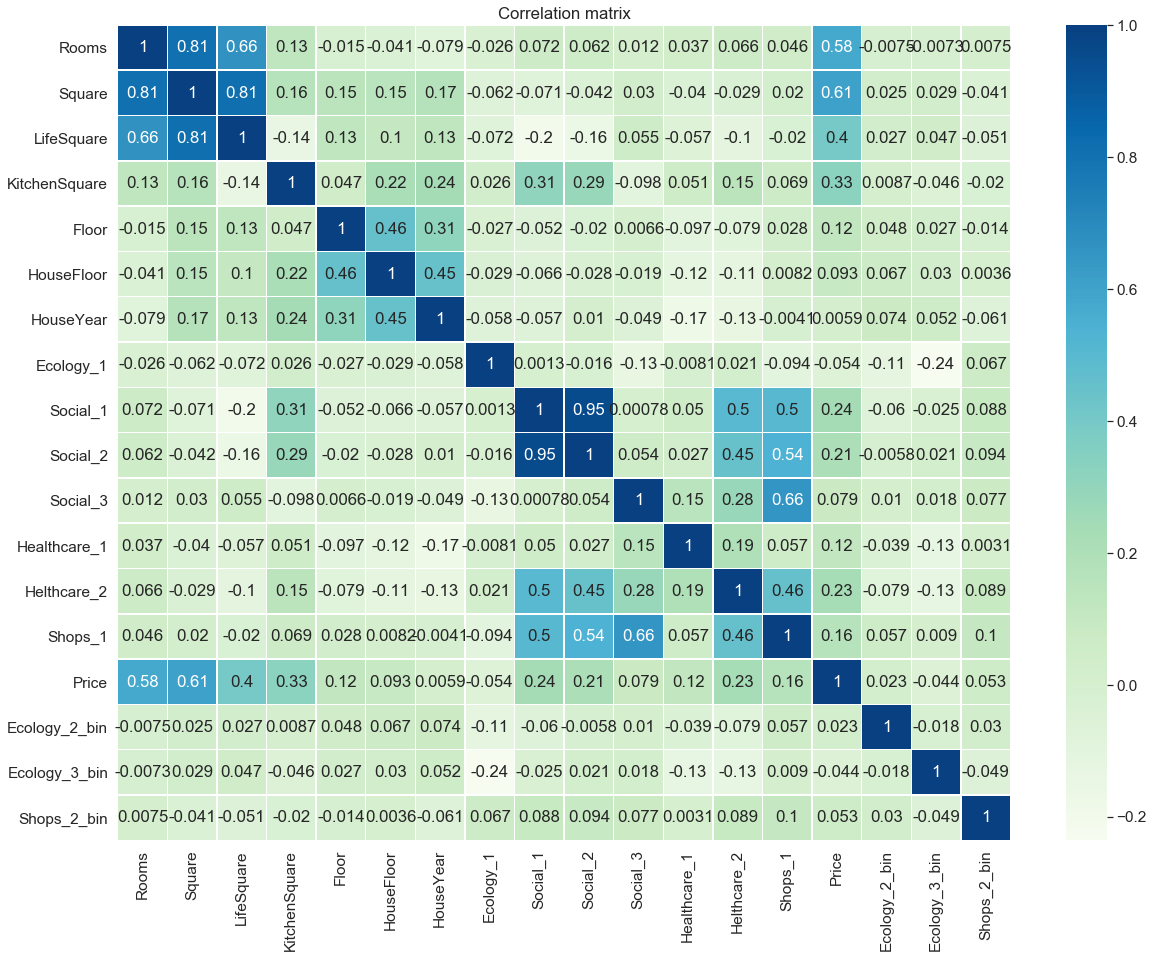

In [925]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Social_1 и Social_2 имеют линеную зависимость.Попробую Social_2 не включать в выборку признаков, так как она имеет меньшую корреляцию с целевой переменной Price.

### Отбор признаков

In [926]:
features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_bin', 'Ecology_3_bin', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']
target = 'Price'

In [927]:
feature_names_for_stand = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1']
other_features = ['Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin']

**Стандартизация тестовых данных**

In [928]:
feature_names_for_stand

['Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1']

In [929]:
other_features

['Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin']

In [930]:
scaler = StandardScaler()
train_stand_features = scaler.fit_transform(train_df[feature_names_for_stand])

In [931]:
train_stand_features= pd.DataFrame(train_stand_features, columns=feature_names_for_stand)

In [932]:
train_stand_features.tail()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
8876,0.144819,-0.271671,-0.404558,-0.568653,-0.476614,-1.278021,-0.901863,0.133974,1.154042,0.585648,-0.098946,-0.955611,1.077316,1.356488
8877,-1.109952,-0.819008,-1.065448,0.862102,0.886985,0.029840,0.840599,-0.999777,0.227512,-0.017216,-0.345922,-0.117517,-0.933397,0.116067
8878,-1.109952,-0.423465,-0.206880,-1.284031,0.692186,0.520287,1.657378,-0.396690,-1.393917,-1.257387,-0.304760,-0.117517,-0.933397,-0.917617
8879,0.144819,-0.690744,-0.180829,0.504413,-1.450613,-1.278021,-1.283026,1.570006,0.227512,-0.146437,0.024542,-0.988349,0.407078,0.116067
8880,-1.109952,-0.994971,-1.024302,0.504413,-0.281814,0.683770,0.296080,-0.999777,0.053787,-0.209288,-0.345922,-1.374657,0.407078,0.736277


In [933]:
train_other_features = train_df[other_features]

In [934]:
train_stand_features.reset_index(inplace=True)

In [935]:
train_stand_features

,index,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,0,0.144819,-0.420842,-0.473291,-0.210964,-0.281814,-0.624091,-0.847411,-0.255590,0.401236,0.589671,-0.140109,-0.117517,-0.933397,1.356488
1,1,1.399590,0.670233,0.232145,0.504413,-0.281814,-0.624091,-0.357343,-0.999192,1.154042,1.176193,-0.304760,-1.099658,-0.263159,2.390172
2,2,0.144819,-0.089772,1.075597,0.862102,-0.087014,0.683770,-0.411795,2.660035,-0.177845,0.026277,-0.222434,0.005578,-0.933397,0.116067
3,3,-1.109952,-0.934411,-0.850164,0.146725,0.497386,-0.133643,-0.466247,-0.896650,0.517052,0.036584,-0.304760,1.307242,0.407078,-0.090670
4,4,1.399590,1.576326,0.673371,1.935169,-0.671414,0.683770,1.439570,1.586826,0.517052,0.524054,-0.181272,-0.117517,-0.933397,0.322804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8876,8876,0.144819,-0.271671,-0.404558,-0.568653,-0.476614,-1.278021,-0.901863,0.133974,1.154042,0.585648,-0.098946,-0.955611,1.077316,1.356488
8877,8877,-1.109952,-0.819008,-1.065448,0.862102,0.886985,0.029840,0.840599,-0.999777,0.227512,-0.017216,-0.345922,-0.117517,-0.933397,0.116067
8878,8878,-1.109952,-0.423465,-0.206880,-1.284031,0.692186,0.520287,1.657378,-0.396690,-1.393917,-1.257387,-0.304760,-0.117517,-0.933397,-0.917617
8879,8879,0.144819,-0.690744,-0.180829,0.504413,-1.450613,-1.278021,-1.283026,1.570006,0.227512,-0.146437,0.024542,-0.988349,0.407078,0.116067


In [936]:
train_other_features.reset_index(inplace=True)

In [937]:
train_other_features.reset_index(inplace=True)

In [938]:
train_other_features

,level_0,index,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,0,0,1,1,1
1,1,1,1,1,1
2,2,3,1,1,1
3,3,4,1,1,1
4,4,5,1,1,1
...,...,...,...,...,...
8876,8876,9995,1,1,1
8877,8877,9996,1,1,0
8878,8878,9997,1,1,0
8879,8879,9998,1,0,1


In [939]:
train_other_features.drop("index", axis=1, inplace=True)

C:\UserData\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [940]:
train_other_features.drop("level_0", axis=1, inplace=True)

In [941]:
train_other_features.reset_index(inplace=True)

In [942]:

train_df_=pd.merge(train_stand_features, train_other_features, on='index', how='inner')


In [943]:
train_df_.tail()

,index,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
8876,8876,0.144819,-0.271671,-0.404558,-0.568653,-0.476614,-1.278021,-0.901863,0.133974,1.154042,0.585648,-0.098946,-0.955611,1.077316,1.356488,1,1,1
8877,8877,-1.109952,-0.819008,-1.065448,0.862102,0.886985,0.029840,0.840599,-0.999777,0.227512,-0.017216,-0.345922,-0.117517,-0.933397,0.116067,1,1,0
8878,8878,-1.109952,-0.423465,-0.206880,-1.284031,0.692186,0.520287,1.657378,-0.396690,-1.393917,-1.257387,-0.304760,-0.117517,-0.933397,-0.917617,1,1,0
8879,8879,0.144819,-0.690744,-0.180829,0.504413,-1.450613,-1.278021,-1.283026,1.570006,0.227512,-0.146437,0.024542,-0.988349,0.407078,0.116067,1,0,1
8880,8880,-1.109952,-0.994971,-1.024302,0.504413,-0.281814,0.683770,0.296080,-0.999777,0.053787,-0.209288,-0.345922,-1.374657,0.407078,0.736277,1,1,1


In [944]:
target_df_ = pd.DataFrame(train_df[target])

In [945]:
target_df_.tail()

,Price
9995,196684.316040
9996,189050.289571
9997,159143.805370
9998,181595.339808
9999,218714.077615


In [946]:
target_df_.reset_index(inplace=True)

In [947]:
target_df_.reset_index(inplace=True)

In [948]:
target_df_.tail()

,level_0,index,Price
8876,8876,9995,196684.316040
8877,8877,9996,189050.289571
8878,8878,9997,159143.805370
8879,8879,9998,181595.339808
8880,8880,9999,218714.077615


In [949]:
target_df_.drop("index", axis=1, inplace=True)

In [950]:
target_df_.drop("level_0", axis=1, inplace=True)

In [951]:
target_df_.reset_index(inplace=True)

In [952]:
target_df_.tail()

,index,Price
8876,8876,196684.316040
8877,8877,189050.289571
8878,8878,159143.805370
8879,8879,181595.339808
8880,8880,218714.077615


In [953]:
train_df_.tail()

,index,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
8876,8876,0.144819,-0.271671,-0.404558,-0.568653,-0.476614,-1.278021,-0.901863,0.133974,1.154042,0.585648,-0.098946,-0.955611,1.077316,1.356488,1,1,1
8877,8877,-1.109952,-0.819008,-1.065448,0.862102,0.886985,0.029840,0.840599,-0.999777,0.227512,-0.017216,-0.345922,-0.117517,-0.933397,0.116067,1,1,0
8878,8878,-1.109952,-0.423465,-0.206880,-1.284031,0.692186,0.520287,1.657378,-0.396690,-1.393917,-1.257387,-0.304760,-0.117517,-0.933397,-0.917617,1,1,0
8879,8879,0.144819,-0.690744,-0.180829,0.504413,-1.450613,-1.278021,-1.283026,1.570006,0.227512,-0.146437,0.024542,-0.988349,0.407078,0.116067,1,0,1
8880,8880,-1.109952,-0.994971,-1.024302,0.504413,-0.281814,0.683770,0.296080,-0.999777,0.053787,-0.209288,-0.345922,-1.374657,0.407078,0.736277,1,1,1


In [954]:
train_df_ = pd.merge(train_df_, target_df_, on='index', how='inner')

In [955]:
train_df_.tail()

,index,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
8876,8876,0.144819,-0.271671,-0.404558,-0.568653,-0.476614,-1.278021,-0.901863,0.133974,1.154042,0.585648,-0.098946,-0.955611,1.077316,1.356488,1,1,1,196684.316040
8877,8877,-1.109952,-0.819008,-1.065448,0.862102,0.886985,0.029840,0.840599,-0.999777,0.227512,-0.017216,-0.345922,-0.117517,-0.933397,0.116067,1,1,0,189050.289571
8878,8878,-1.109952,-0.423465,-0.206880,-1.284031,0.692186,0.520287,1.657378,-0.396690,-1.393917,-1.257387,-0.304760,-0.117517,-0.933397,-0.917617,1,1,0,159143.805370
8879,8879,0.144819,-0.690744,-0.180829,0.504413,-1.450613,-1.278021,-1.283026,1.570006,0.227512,-0.146437,0.024542,-0.988349,0.407078,0.116067,1,0,1,181595.339808
8880,8880,-1.109952,-0.994971,-1.024302,0.504413,-0.281814,0.683770,0.296080,-0.999777,0.053787,-0.209288,-0.345922,-1.374657,0.407078,0.736277,1,1,1,218714.077615


In [956]:
train_df_.drop("index", axis=1, inplace=True)

In [957]:
train_df_.tail()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
8876,0.144819,-0.271671,-0.404558,-0.568653,-0.476614,-1.278021,-0.901863,0.133974,1.154042,0.585648,-0.098946,-0.955611,1.077316,1.356488,1,1,1,196684.316040
8877,-1.109952,-0.819008,-1.065448,0.862102,0.886985,0.029840,0.840599,-0.999777,0.227512,-0.017216,-0.345922,-0.117517,-0.933397,0.116067,1,1,0,189050.289571
8878,-1.109952,-0.423465,-0.206880,-1.284031,0.692186,0.520287,1.657378,-0.396690,-1.393917,-1.257387,-0.304760,-0.117517,-0.933397,-0.917617,1,1,0,159143.805370
8879,0.144819,-0.690744,-0.180829,0.504413,-1.450613,-1.278021,-1.283026,1.570006,0.227512,-0.146437,0.024542,-0.988349,0.407078,0.116067,1,0,1,181595.339808
8880,-1.109952,-0.994971,-1.024302,0.504413,-0.281814,0.683770,0.296080,-0.999777,0.053787,-0.209288,-0.345922,-1.374657,0.407078,0.736277,1,1,1,218714.077615


In [958]:
train_df_.mean()

Rooms            1.630144e-16
Square           5.229212e-17
LifeSquare      -2.275951e-16
KitchenSquare    8.353238e-17
Floor           -9.773988e-17
HouseFloor       1.379872e-16
HouseYear        3.235086e-15
Ecology_1        2.625232e-19
Social_1        -3.367485e-18
Social_2        -1.035904e-16
Social_3         1.488319e-16
Healthcare_1     3.091273e-16
Helthcare_2     -9.219564e-16
Shops_1         -2.736492e-17
Ecology_2_bin    9.899786e-01
Ecology_3_bin    9.699358e-01
Shops_2_bin      9.293998e-01
Price            2.149395e+05
dtype: float64

In [959]:
train_df_.std()

Rooms                1.000056
Square               1.000056
LifeSquare           1.000056
KitchenSquare        1.000056
Floor                1.000056
HouseFloor           1.000056
HouseYear            1.000056
Ecology_1            1.000056
Social_1             1.000056
Social_2             1.000056
Social_3             1.000056
Healthcare_1         1.000056
Helthcare_2          1.000056
Shops_1              1.000056
Ecology_2_bin        0.099610
Ecology_3_bin        0.170774
Shops_2_bin          0.256170
Price            89654.209673
dtype: float64

**Стандартизация валидационных данных**

In [960]:
valid_stand_features = scaler.transform(train_df[feature_names_for_stand])


In [961]:
valid_stand_features= pd.DataFrame(valid_stand_features, columns=feature_names_for_stand)

In [962]:
valid_stand_features.reset_index(inplace=True)

In [963]:
valid_df = pd.merge(valid_stand_features, train_other_features, on='index', how='inner')

In [964]:
valid_df.drop("index", axis=1, inplace=True)

In [965]:
valid_df.tail()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
8876,0.144819,-0.271671,-0.404558,-0.568653,-0.476614,-1.278021,-0.901863,0.133974,1.154042,0.585648,-0.098946,-0.955611,1.077316,1.356488,1,1,1
8877,-1.109952,-0.819008,-1.065448,0.862102,0.886985,0.029840,0.840599,-0.999777,0.227512,-0.017216,-0.345922,-0.117517,-0.933397,0.116067,1,1,0
8878,-1.109952,-0.423465,-0.206880,-1.284031,0.692186,0.520287,1.657378,-0.396690,-1.393917,-1.257387,-0.304760,-0.117517,-0.933397,-0.917617,1,1,0
8879,0.144819,-0.690744,-0.180829,0.504413,-1.450613,-1.278021,-1.283026,1.570006,0.227512,-0.146437,0.024542,-0.988349,0.407078,0.116067,1,0,1
8880,-1.109952,-0.994971,-1.024302,0.504413,-0.281814,0.683770,0.296080,-0.999777,0.053787,-0.209288,-0.345922,-1.374657,0.407078,0.736277,1,1,1


**Стандартизация тестовых данных**

In [966]:
test_stand_features = scaler.transform(test_df[feature_names_for_stand])

In [967]:
test_stand_features= pd.DataFrame(test_stand_features, columns=feature_names_for_stand)

In [968]:
test_stand_features.tail()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
4995,1.399590,0.759621,0.947788,-0.210964,-0.671414,-0.624091,-0.629603,-0.998359,0.574961,0.090887,-0.345922,-0.235374,-0.263159,-0.710880
4996,-1.109952,-0.900556,-0.981126,1.219791,0.692186,0.683770,1.766282,-0.940250,-1.451825,-1.349149,-0.345922,-0.235374,-0.933397,-0.710880
4997,1.399590,1.419630,0.779711,0.862102,2.834984,1.501183,0.241628,-0.240885,2.775470,3.382003,-0.263597,-0.235374,2.417792,2.183435
4998,0.144819,1.633076,2.019606,-1.284031,-0.866213,-0.133643,-0.411795,-0.396690,-1.393917,-1.257387,-0.304760,-0.235374,-0.933397,-0.917617
4999,0.144819,0.354170,0.639597,-1.284031,0.302586,0.683770,-0.411795,-0.999124,-0.235754,0.192957,5.458017,-0.044184,1.077316,3.837330


In [969]:
test_stand_features.reset_index(inplace=True)

In [970]:
test_stand_features.tail()

,index,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
4995,4995,1.399590,0.759621,0.947788,-0.210964,-0.671414,-0.624091,-0.629603,-0.998359,0.574961,0.090887,-0.345922,-0.235374,-0.263159,-0.710880
4996,4996,-1.109952,-0.900556,-0.981126,1.219791,0.692186,0.683770,1.766282,-0.940250,-1.451825,-1.349149,-0.345922,-0.235374,-0.933397,-0.710880
4997,4997,1.399590,1.419630,0.779711,0.862102,2.834984,1.501183,0.241628,-0.240885,2.775470,3.382003,-0.263597,-0.235374,2.417792,2.183435
4998,4998,0.144819,1.633076,2.019606,-1.284031,-0.866213,-0.133643,-0.411795,-0.396690,-1.393917,-1.257387,-0.304760,-0.235374,-0.933397,-0.917617
4999,4999,0.144819,0.354170,0.639597,-1.284031,0.302586,0.683770,-0.411795,-0.999124,-0.235754,0.192957,5.458017,-0.044184,1.077316,3.837330


In [971]:
test_other_features = test_df[other_features]

In [972]:
test_other_features

,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,0
...,...,...,...
4995,1,1,1
4996,1,1,1
4997,1,1,1
4998,1,1,0


In [973]:
test_other_features.reset_index(inplace=True)

In [974]:
test_other_features

,index,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,0,1,1,1
1,1,1,1,1
2,2,1,1,1
3,3,1,1,1
4,4,1,1,0
...,...,...,...,...
4995,4995,1,1,1
4996,4996,1,1,1
4997,4997,1,1,1
4998,4998,1,1,0


In [975]:
test_df_ = pd.merge(test_stand_features, test_other_features, on='index', how='inner')

In [976]:
test_df_.drop("index", axis=1, inplace=True)

In [977]:
test_df_

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,0.144819,-0.303668,-0.207922,-0.210964,-0.476614,0.193322,-0.684055,1.592844,-0.872743,-0.724664,-0.304760,-0.235374,-0.933397,-0.917617,1,1,1
1,0.144819,0.890860,1.218715,-1.284031,-0.476614,-1.931952,-0.411795,-0.366424,-1.162284,-1.054253,-0.222434,-0.235374,-0.933397,-0.504144,1,1,1
2,-1.109952,-2.540099,-1.370784,1.935169,-1.255813,-1.278021,-4.114527,-0.999777,0.227512,0.479556,3.235231,4.743427,2.417792,0.116067,1,1,1
3,0.144819,1.124053,1.023011,0.862102,2.640184,1.501183,1.221762,-0.148335,-0.177845,-0.263340,-0.222434,-0.235374,1.077316,-0.297407,1,1,1
4,-1.109952,-0.448852,0.454151,-1.284031,1.666185,0.683770,1.766282,-0.396690,-1.393917,-1.257387,-0.304760,-0.235374,-0.933397,-0.917617,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.399590,0.759621,0.947788,-0.210964,-0.671414,-0.624091,-0.629603,-0.998359,0.574961,0.090887,-0.345922,-0.235374,-0.263159,-0.710880,1,1,1
4996,-1.109952,-0.900556,-0.981126,1.219791,0.692186,0.683770,1.766282,-0.940250,-1.451825,-1.349149,-0.345922,-0.235374,-0.933397,-0.710880,1,1,1
4997,1.399590,1.419630,0.779711,0.862102,2.834984,1.501183,0.241628,-0.240885,2.775470,3.382003,-0.263597,-0.235374,2.417792,2.183435,1,1,1
4998,0.144819,1.633076,2.019606,-1.284031,-0.866213,-0.133643,-0.411795,-0.396690,-1.393917,-1.257387,-0.304760,-0.235374,-0.933397,-0.917617,1,1,0


### Разбиение данные на train и test

In [978]:
X = train_df_[features]
y = train_df_[target]

In [979]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [980]:
X_test = test_df_[features]
X_test.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2_bin,Ecology_3_bin,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2_bin
0,0.144819,-0.303668,-0.207922,-0.210964,-0.476614,0.193322,-0.684055,1.592844,1,1,-0.872743,-0.724664,-0.304760,-0.235374,-0.933397,-0.917617,1
1,0.144819,0.890860,1.218715,-1.284031,-0.476614,-1.931952,-0.411795,-0.366424,1,1,-1.162284,-1.054253,-0.222434,-0.235374,-0.933397,-0.504144,1
2,-1.109952,-2.540099,-1.370784,1.935169,-1.255813,-1.278021,-4.114527,-0.999777,1,1,0.227512,0.479556,3.235231,4.743427,2.417792,0.116067,1
3,0.144819,1.124053,1.023011,0.862102,2.640184,1.501183,1.221762,-0.148335,1,1,-0.177845,-0.263340,-0.222434,-0.235374,1.077316,-0.297407,1
4,-1.109952,-0.448852,0.454151,-1.284031,1.666185,0.683770,1.766282,-0.396690,1,1,-1.393917,-1.257387,-0.304760,-0.235374,-0.933397,-0.917617,0


### Построение модели

In [1006]:
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

R2:	0.959
MAE:	10600.905
MSE:	316779617.449


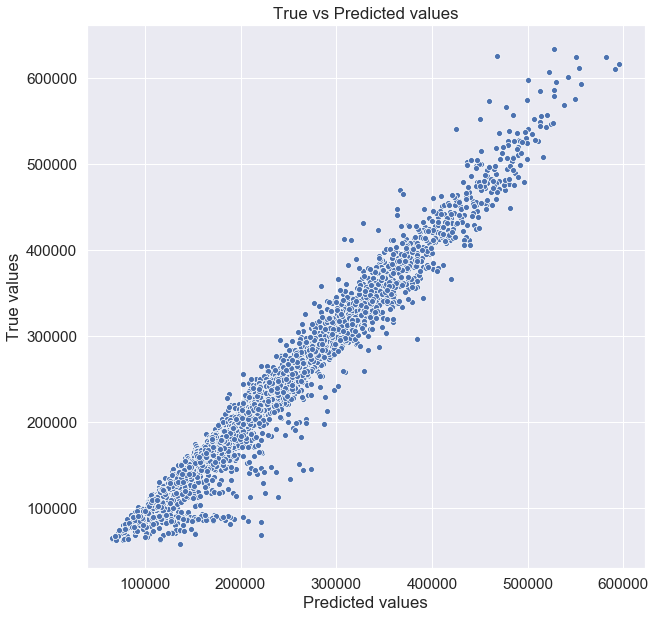

In [1007]:
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.709
MAE:	30068.561
MSE:	2529582978.859


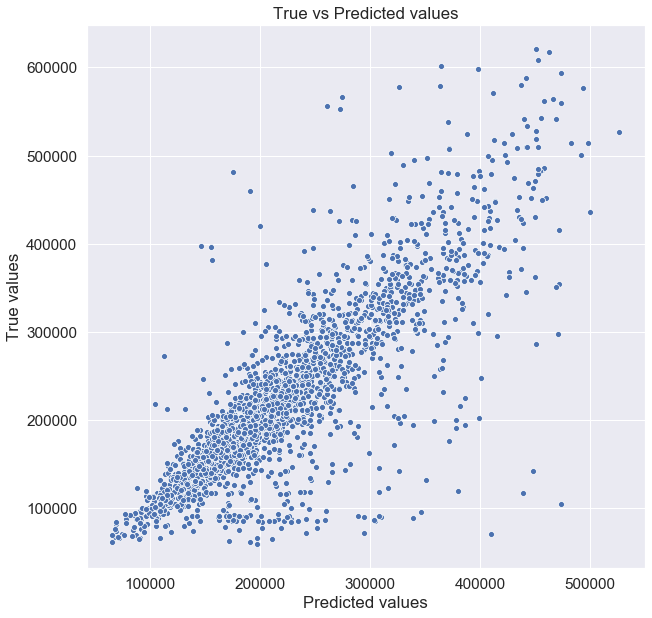

In [1008]:
y_valid_preds = rf_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

### Предсказание цены для тестового датасета 

In [985]:
price = rf_model.predict(X_test)
test_df_.reset_index(inplace=True)
pd.DataFrame({ 'Id': test_df_['index'], 'Price': price }).to_csv(PREPARED_DATASET_PATH, index=False)

In [1017]:
result = pd.read_csv(PREPARED_DATASET_PATH)
result.tail()

,Id,Price
4995,4995,253987.810037
4996,4996,137066.263649
4997,4997,324901.886051
4998,4998,204763.910703
4999,4999,185053.824084
